In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from tqdm.notebook import tqdm, trange

%matplotlib inline

In [26]:
# Попробовать другие лоссы
# LSTM
# Соединять свои траектории
# LSTM encode decode
# Гришин + Махоткин
# Разобраться с лоссом

## Конфигурация

In [2]:
config = dict(
    include_measurements_error=True,
    include_velocity_estimation=True,
    include_acceleration_estimation=False,
    track_length=16,
    batch_size=128,
    learning_rate=0.0005,
    hidden_size=64,
    output_size=8,
    n_epochs=5
)

## Кастомный Dataset

In [3]:
class SiameseNetworkDataset(torch.utils.data.Dataset):

    def __init__(self, source_file):
        self.data = pd.read_csv(source_file)
        self.data = self.data.sort_values(by=['rs_id', 'id', 'time']).reset_index(drop=True)
        self.data = self.data.drop(columns=['load_time'])

        if not config['include_measurements_error']:
            self.data = self.data.drop(columns=[f'{axis}_err' for axis in ('x', 'y', 'z')])

        if not config['include_velocity_estimation']:
            self.data = self.data.drop(columns=[f'v_{axis}_est' for axis in ('x', 'y', 'z')])
        
        if not config['include_acceleration_estimation']:
            self.data = self.data.drop(columns=[f'a_{axis}_est' for axis in ('x', 'y', 'z')])

        self.data = self.data.dropna()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        while True:
            rs_id_1, rs_id_2 = np.random.choice(self.data['rs_id'].unique(), 2)
            if rs_id_1 == rs_id_2:
                continue
            
            id_1 = np.random.choice(self.data[self.data['rs_id'] == rs_id_1]['id'].unique())
            id_2 = np.random.choice(self.data[self.data['rs_id'] == rs_id_2]['id'].unique())

            t_min_1, t_max_1 = self.get_track_time_range((rs_id_1, id_1))
            t_min_2, t_max_2 = self.get_track_time_range((rs_id_2, id_2))

            t_min, t_max = max(t_min_1, t_min_2), min(t_max_1, t_max_2)

            if t_max <= t_min:
                continue
            
            t_min_ = np.random.randint(t_min, t_max)

            if t_min_ + config['track_length'] >= t_max:
                continue
            
            t_max_ = np.random.randint(t_min_ + config['track_length'], t_max)
            
            track_1 = self.get_track((rs_id_1, id_1), t_min_, t_max_)
            track_2 = self.get_track((rs_id_2, id_2), t_min_, t_max_)

            if len(track_1) < config['track_length'] or len(track_2) < config['track_length']:
                continue
            
            # track_1 = pd.concat([track_1.head(1), track_1.diff().dropna()])
            # track_2 = pd.concat([track_2.head(1), track_2.diff().dropna()])

            track_1 = self.compress_to_length(track_1)
            track_2 = self.compress_to_length(track_2)
            
            x_1 = torch.tensor(track_1.drop(columns=['rs_id', 'id']).values, dtype=torch.float32)
            x_2 = torch.tensor(track_2.drop(columns=['rs_id', 'id']).values, dtype=torch.float32)
            y = torch.tensor(0.0) if id_1 == id_2 else torch.tensor(1.0)
        
            return x_1.reshape((-1,)), x_2.reshape((-1,)), y

    def get_track(self, track_id, t_min=None, t_max=None):
        if t_min is None or t_max is None:
            return self.data[(self.data['rs_id'] == track_id[0]) & (self.data['id'] == track_id[1])]
        return self.data[(self.data['rs_id'] == track_id[0]) & (self.data['id'] == track_id[1]) &
                         (self.data['time'] >= t_min) & (self.data['time'] <= t_max)]

    def get_track_time_range(self, track_id):
        return self.get_track(track_id)['time'].min(), self.get_track(track_id)['time'].max()

    @staticmethod
    def compress_to_length(track, target_length=config['track_length']):
        if len(track) < target_length:
            raise RuntimeError(f'Track length must be {target_length} or larger.')
        times = track['time'].unique()
        times_crapped = [times[int(i * (len(times) - 1) / (target_length - 1))] for i in range(target_length)]
        return track[track['time'].isin(times_crapped)]

## Сиамская нейронная сеть (Siamese Neural Network)

In [4]:
class TrackIdentificationSiameseNetwork(torch.nn.Module):

    def __init__(self, track_length, track_features, hidden_size, output_size):
        super(TrackIdentificationSiameseNetwork, self).__init__()

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(track_length * track_features, hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(hidden_size, output_size)
        )
        
    def forward_once(self, x):
        out = self.fc_layers(x)
        return out

    def forward(self, x_1, x_2):
        out_1 = self.forward_once(x_1)
        out_2 = self.forward_once(x_2)

        return out_1, out_2

## Контрастная функция потерь (Contrastive Loss)

In [5]:
class TrackIdentificationContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(TrackIdentificationContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x_1, x_2, y):
      euclidean_distance = torch.nn.functional.pairwise_distance(x_1, x_2, keepdim=True)

      loss_contrastive = torch.mean((1 - y) * torch.pow(euclidean_distance, 2) +
                                    (y) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

      return loss_contrastive

## Обучение нейросети

#### Подготовка Dataset и DataLoader для обучения

In [6]:
source_file = 'data/train/3ao_3rs_1003223723.csv'

In [23]:
pd.read_csv(source_file)

,rs_id,id,time,x,y,z,x_err,y_err,z_err,v_x_est,v_y_est,v_z_est,a_x_est,a_y_est,a_z_est,load_time
0,0,0,0,0.061388,-0.084797,9999.922460,0.1,0.1,0.1,NaN,NaN,NaN,NaN,NaN,NaN,10010
1,0,1,0,0.011925,999.902434,9999.931602,0.1,0.1,0.1,NaN,NaN,NaN,NaN,NaN,NaN,10010
2,0,0,10,4.940337,0.073699,10000.025548,0.1,0.1,0.1,0.487895,0.015850,0.010309,NaN,NaN,NaN,10010
3,0,1,10,15.010189,999.902129,9999.946421,0.1,0.1,0.1,1.499826,-0.000030,0.001482,NaN,NaN,NaN,10010
4,0,0,20,10.015849,-0.057727,9999.906539,0.1,0.1,0.1,0.507551,-0.013143,-0.011901,0.001966,-0.002899,-0.002221,10010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999,1,1,9980,14969.901120,1000.082232,10000.044518,0.1,0.1,0.1,1.489917,0.008494,0.002613,-0.001564,0.001841,0.000982,10010
4000,1,0,9990,4995.052656,-0.058167,10000.095496,0.1,0.1,0.1,0.512666,-0.000404,-0.000027,0.002738,0.000186,-0.000378,10010
4001,1,1,9990,14985.039650,1000.084912,10000.083433,0.1,0.1,0.1,1.513853,0.000268,0.003891,0.002394,-0.000823,0.000128,10010
4002,1,0,10000,4999.919049,0.084970,9999.903714,0.1,0.1,0.1,0.486639,0.014314,-0.019178,-0.002603,0.001472,-0.001915,10010


In [7]:
train_dataset = SiameseNetworkDataset(source_file=source_file)

In [24]:
len(train_dataset)

34362

In [8]:
train_dataset[0]

(tensor([ 3.5258e+05, -3.8331e+04,  7.8011e+03,  9.9980e+03,  2.5000e+00,
          2.5000e+00,  2.5000e+00,  2.6059e-01,  3.0641e-02, -3.2732e-02,
          3.5418e+05, -3.7911e+04,  7.7982e+03,  9.9978e+03,  2.5000e+00,
          2.5000e+00,  2.5000e+00,  2.7733e-01, -3.5278e-02, -4.4516e-02,
          3.5578e+05, -3.7497e+04,  7.8018e+03,  9.9984e+03,  2.5000e+00,
          2.5000e+00,  2.5000e+00,  2.4600e-01,  4.1190e-02, -3.8216e-02,
          3.5748e+05, -3.7055e+04,  7.8016e+03,  1.0002e+04,  2.5000e+00,
          2.5000e+00,  2.5000e+00,  2.7532e-01, -2.2102e-03,  3.7410e-02,
          3.5908e+05, -3.6641e+04,  7.8023e+03,  1.0001e+04,  2.5000e+00,
          2.5000e+00,  2.5000e+00,  2.3419e-01,  2.6793e-02,  2.3646e-02,
          3.6068e+05, -3.6222e+04,  7.8006e+03,  9.9986e+03,  2.5000e+00,
          2.5000e+00,  2.5000e+00,  2.9130e-01, -6.1458e-03, -3.2078e-02,
          3.6238e+05, -3.5782e+04,  7.8007e+03,  1.0001e+04,  2.5000e+00,
          2.5000e+00,  2.5000e+00,  2.

In [9]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               shuffle=True,
                                               batch_size=config['batch_size'])

#### Алгоритм обучения

In [10]:
# time, x, y, z
track_features = 4
if config['include_measurements_error']:
    # x_err, y_err, z_err
    track_features += 3
if config['include_velocity_estimation']:
    # v_x_est, v_y_est, v_z_est
    track_features += 3
if config['include_acceleration_estimation']:
    # a_x_est, a_y_est, a_z_est
    track_features += 3

model = TrackIdentificationSiameseNetwork(track_length=config['track_length'],
                                          track_features=track_features,
                                          hidden_size=config['hidden_size'],
                                          output_size=config['output_size'])
criterion = TrackIdentificationContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [11]:
loss_history = []
lr_history = []

epoch_progress = trange(config['n_epochs'])
for epoch in epoch_progress:
    epoch_progress.set_description(f'Epoch {epoch + 1}')

    for i, (x_1, x_2, y) in enumerate(train_dataloader):
        out_1, out_2 = model(x_1, x_2)

        loss = criterion(out_1, out_2, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lr_history.append(optimizer.param_groups[0]['lr'])
        loss_history.append(loss.item())
        
        epoch_progress.set_postfix({'loss': loss.item()})

    optimizer.param_groups[0]['lr'] *= 0.1

  0%|          | 0/5 [00:00<?, ?it/s]

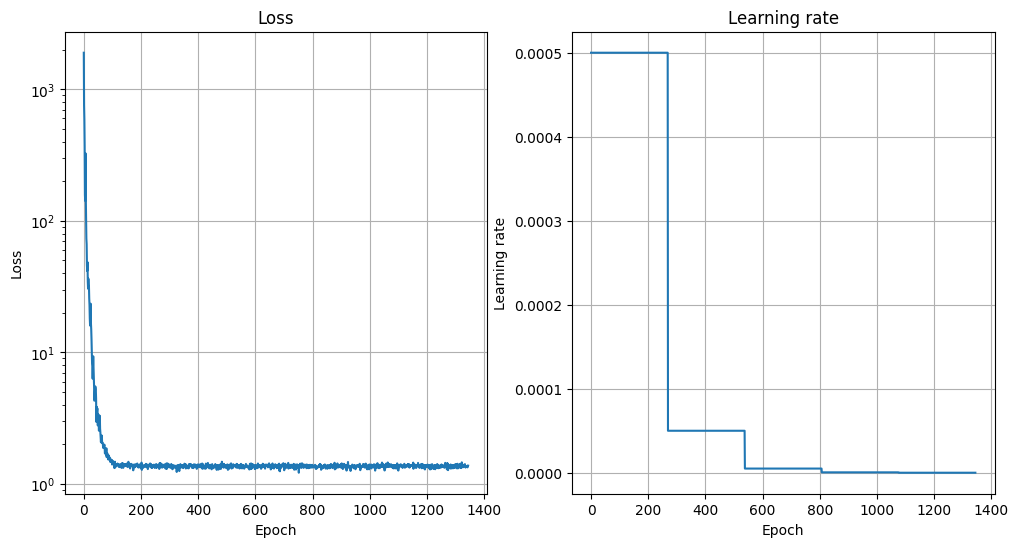

In [12]:
fig, axis = plt.subplots(1, 2, figsize=(12, 6))

# Loss plot
axis[0].set_title('Loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')
axis[0].semilogy()
axis[0].grid()
axis[0].plot(loss_history)

# Learning rate plot
axis[1].set_title('Learning rate')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Learning rate')
axis[1].grid()
axis[1].plot(lr_history)

#### Пример работы нейросети

In [13]:
def print_example(dataset, model, criterion):
    x_1, x_2, y = train_dataset[0]
    with torch.inference_mode():
        out_1, out_2 = model(x_1, x_2)
        loss = criterion(out_1, out_2, y)

    print('§ Входные данные:')
    print(f'x_1 = \n{x_1},\nx_2 = \n{x_2},\ny   = {y}')
    print(criterion(x_1, x_2, y))
    print()
    print('§ Выходные данные:')
    print(f'out_1 = {out_1},\nout_2 = {out_2}')
    print()
    print('§ Значение функции потерь:')
    print(f'loss = {loss}')

In [14]:
print_example(train_dataset, model, criterion)

§ Входные данные:
x_1 = 
tensor([ 3.4370e+05, -4.0636e+04,  5.0001e+03,  9.9984e+03,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.7355e-01,  1.8278e-02, -1.7818e-02,
         3.4480e+05, -4.0352e+04,  5.0014e+03,  9.9990e+03,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.7473e-01,  2.8858e-02, -2.8291e-02,
         3.4600e+05, -4.0041e+04,  5.0021e+03,  1.0001e+04,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.5560e-01,  3.1407e-02, -1.2634e-02,
         3.4720e+05, -3.9729e+04,  4.9994e+03,  9.9981e+03,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.6665e-01, -2.4167e-03, -1.3012e-02,
         3.4840e+05, -3.9418e+04,  4.9980e+03,  1.0001e+04,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.4202e-01, -3.2350e-02,  7.0035e-06,
         3.4960e+05, -3.9105e+04,  5.0010e+03,  9.9987e+03,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.5518e-01,  2.2073e-03,  2.9358e-03,
         3.5070e+05, -3.8818e+04,  5.0018e+03,  9.9975e+03,  2.5000e+00,
         2.5000e+00,  2.50

#### Сохранение модели

In [15]:
model_state_path = 'models/siamese/model_{}.pt'.format(datetime.datetime.now().strftime('%d%m%H%M%S'))
print(model_state_path)

models/siamese/model_1103210003.pt


In [16]:
torch.save(model.state_dict(), model_state_path)

## Тестирование нейросети

#### Загрузка модели (опционально)

In [17]:
# model = TrackIdentificationSiameseNetwork(track_length=config['track_length'],
#                                           track_features=track_features,
#                                           hidden_size=config['hidden_size'],
#                                           output_size=config['output_size'])
# model.load_state_dict(torch.load(model_state_path))

#### Подготовка Dataset и DataLoader для тестирования

In [18]:
source_file = 'data/test/2ao_2rs_0103175435.csv'

In [19]:
test_dataset = SiameseNetworkDataset(source_file=source_file)

In [20]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=config['batch_size'])

#### Расчет метрик

In [21]:
losses = []

for i, (x_1, x_2, y) in enumerate(test_dataloader):
    with torch.inference_mode():
        out_1, out_2 = model(x_1, x_2)
        loss = criterion(out_1, out_2, y)
        losses.append(loss.item())

print(np.mean(losses))

1645.2041206359863


In [22]:
print_example(test_dataset, model, criterion)

§ Входные данные:
x_1 = 
tensor([ 6.8150e+05,  4.7192e+04,  7.8036e+03,  1.0000e+04,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.5518e-01, -8.2123e-03,  1.4837e-02,
         6.8180e+05,  4.7269e+04,  7.8055e+03,  1.0002e+04,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.8812e-01,  4.2608e-02,  3.2157e-02,
         6.8210e+05,  4.7346e+04,  7.8028e+03,  1.0001e+04,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.4616e-01,  3.1192e-03,  1.6845e-02,
         6.8250e+05,  4.7449e+04,  7.8056e+03,  9.9983e+03,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.2886e-01,  4.2195e-02, -3.6367e-02,
         6.8280e+05,  4.7526e+04,  7.8051e+03,  1.0000e+04,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.2592e-01, -2.4909e-03, -2.0671e-02,
         6.8320e+05,  4.7633e+04,  7.8057e+03,  1.0001e+04,  2.5000e+00,
         2.5000e+00,  2.5000e+00,  2.8460e-01,  1.0239e-02,  1.6730e-03,
         6.8350e+05,  4.7708e+04,  7.8042e+03,  1.0000e+04,  2.5000e+00,
         2.5000e+00,  2.50